# Load data

In [1]:
import xarray as xr

data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat_EOFs = xr.open_dataset(data_dir + '/ds_sat_EOFs.nc')
ds_sat_EOFs.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat                    (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                    (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * age                    (age) float32 1.11e+04 1.13e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_std                (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float32 ...
    sat_centered_weighted  (age, lat, lon) float32 ...
    EOF1                   (lat, lon) float32 ...
    EOF2                   (lat, lon) float32 ...>

In [17]:
ds_sat_EOFs['sat'].isel(lat=0, lon=0).values.shape

(65,)

In [20]:
ds_sat_EOFs['age'].values

array([11100., 11300., 11500., 11700., 11900., 12100., 12300., 12500.,
       12700., 12900., 13100., 13300., 13500., 13700., 13900., 14100.,
       14300., 14500., 14700., 14900., 15100., 15300., 15500., 15700.,
       15900., 16100., 16300., 16500., 16700., 16900., 17100., 17300.,
       17500., 17700., 17900., 18100., 18300., 18500., 18700., 18900.,
       19100., 19300., 19500., 19700., 19900., 20100., 20300., 20500.,
       20700., 20900., 21100., 21300., 21500., 21700., 21900., 22100.,
       22300., 22500., 22700., 22900., 23100., 23300., 23500., 23700.,
       23900.], dtype=float32)

# Find the transition accroding to the method introduced in WAIS (2015)： https://www.nature.com/articles/nature14401

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


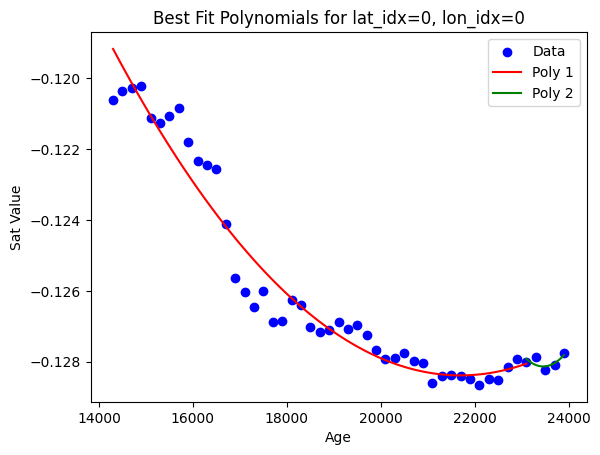

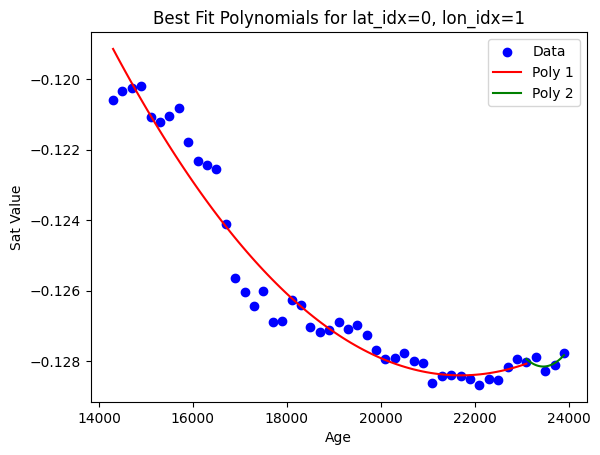

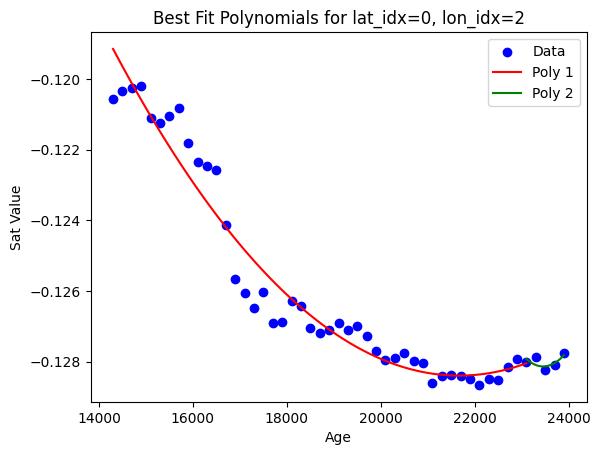

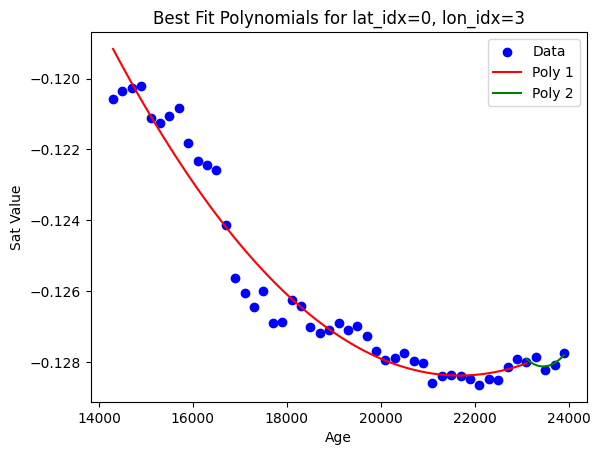

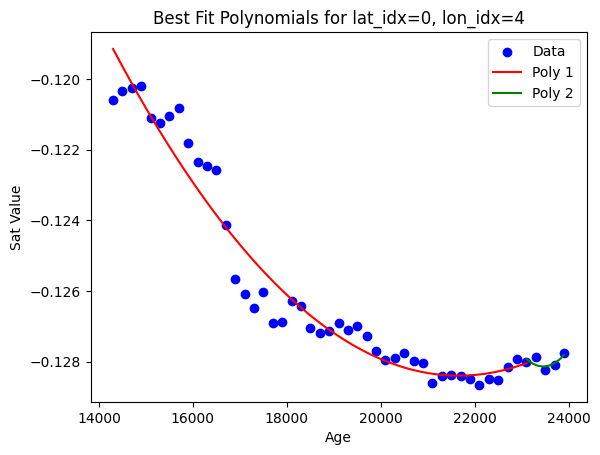

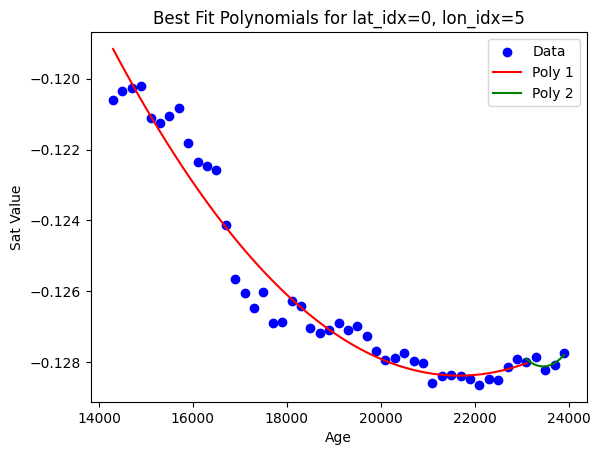

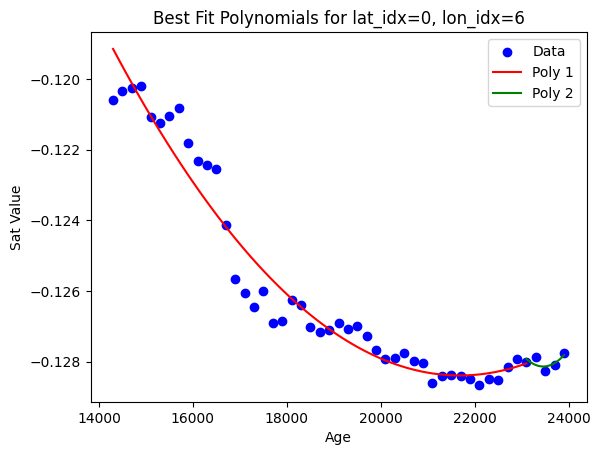

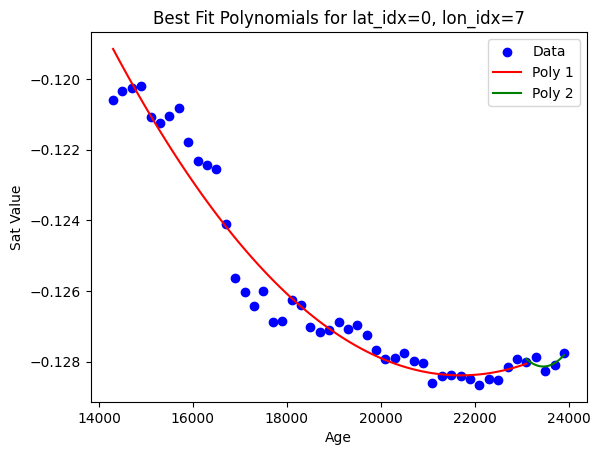

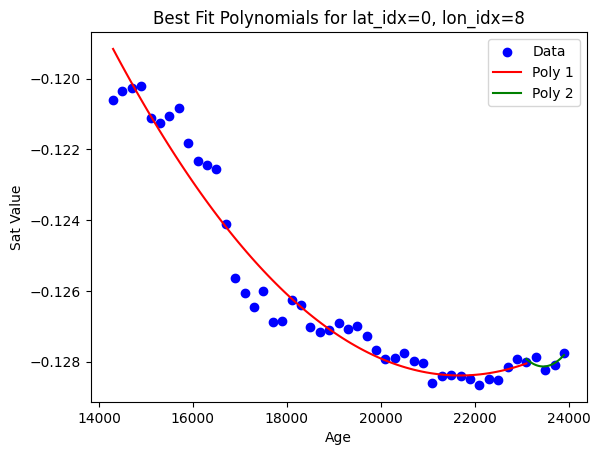

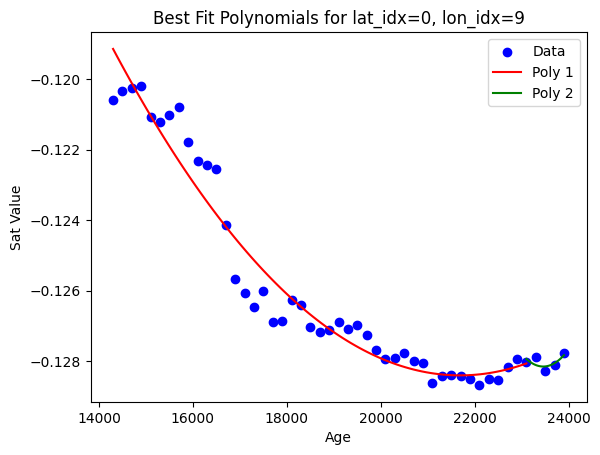

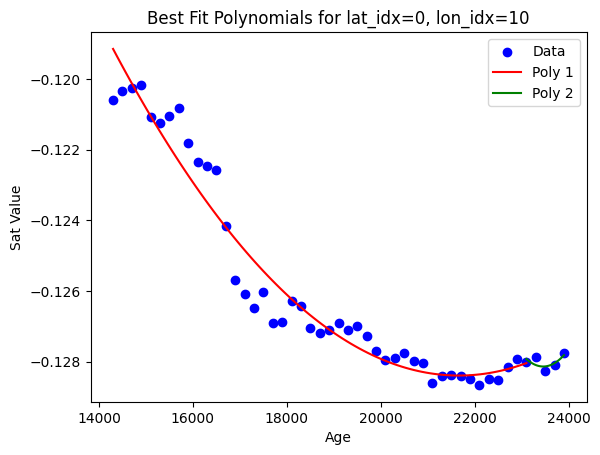

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import xarray as xr

# Function for polynomial fit
def poly_fit(x, *params):
    return sum(p * x**i for i, p in enumerate(params))

# Order of the polynomial
n = 2  # User-defined: change as needed

# Initialize a 2D array to store the 'best_fit_T' values
T_values_array = np.zeros((len(ds_sat_EOFs['lat']), len(ds_sat_EOFs['lon'])))
interval_L_indx = 16
interval_R_indx = 65

cropped_age = ds_sat_EOFs['age'].values[interval_L_indx:interval_R_indx]
transitions = cropped_age[3:-3]

counter = 0

# Loop through each lat-lon grid point
for lat_idx in range(len(ds_sat_EOFs['lat'])):
    for lon_idx in range(len(ds_sat_EOFs['lon'])):
        
        time_series_data = ds_sat_EOFs['sat'].isel(lat=lat_idx, lon=lon_idx).values[interval_L_indx:interval_R_indx]

        # Skip if time_series_data is all zero
        if np.all(time_series_data == 0):
            continue

        else:
            # Initialize variables to store the best fit information
            best_residuals = float('inf')
            best_fit_T = None
            
            # Loop through each possible transition point T
            for T_idx, T in enumerate(transitions):
                x1, y1 = cropped_age[:T_idx + 3], time_series_data[:T_idx + 3]
                x2, y2 = cropped_age[T_idx + 2:], time_series_data[T_idx + 2:]
                
                # Fit the two polynomials
                popt1, _ = curve_fit(poly_fit, x1, y1, p0=np.ones(n+1))
                popt2, _ = curve_fit(poly_fit, x2, y2, p0=np.ones(n+1))
                
                # Calculate residuals
                residuals = np.sum((poly_fit(x1, *popt1) - y1)**2) + np.sum((poly_fit(x2, *popt2) - y2)**2)
                
                # Update best fit if this fit is better
                if residuals < best_residuals:
                    best_residuals = residuals
                    best_fit_T = T  # Storing the age value itself instead of the intersection

            # Store the best_fit_T in the 2D array
            T_values_array[lat_idx, lon_idx] = best_fit_T

            if counter <= 10:
                plt.figure()
                plt.scatter(cropped_age, time_series_data, label='Data', color='blue')
                
                # Extend x-range for plotting
                extended_x1 = np.linspace(min(x1), max(x1), 100)
                extended_x2 = np.linspace(min(x2), max(x2), 100)
                
                plt.plot(extended_x1, poly_fit(extended_x1, *popt1), label=f'Poly 1', color='red')
                plt.plot(extended_x2, poly_fit(extended_x2, *popt2), label=f'Poly 2', color='green')
                
                plt.legend()
                plt.xlabel('Age')
                plt.ylabel('Sat Value')
                plt.title(f'Best Fit Polynomials for lat_idx={lat_idx}, lon_idx={lon_idx}')
                plt.show()
                
            counter += 1


# Plot the spatial distribution of the transition age

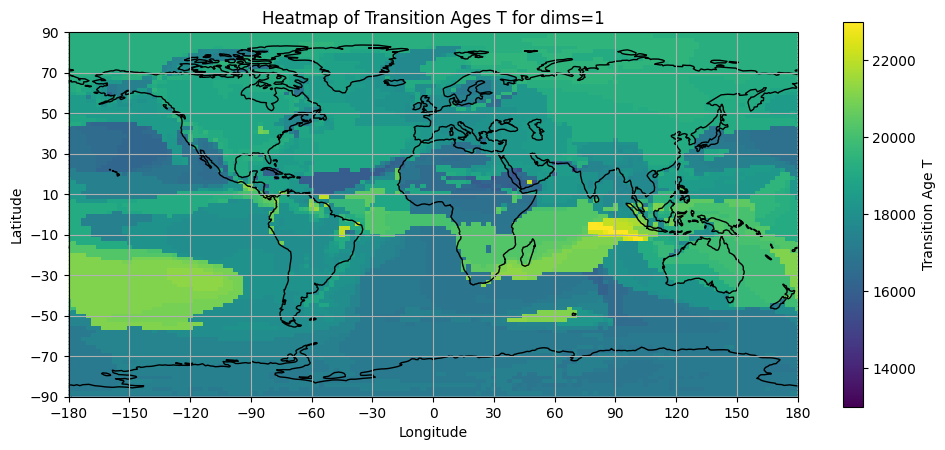

In [32]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Create a figure with a single subplot with map projection
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastline to the subplot
ax.add_feature(cfeature.COASTLINE)

# Using pcolormesh for the heatmap of transition ages
c = ax.pcolormesh(ds_sat_EOFs['lon'], ds_sat_EOFs['lat'], T_values_array, shading='auto', vmin=13000, vmax=23000)

# Adding colorbar and labels
plt.colorbar(c, ax=ax, shrink=0.5, label='Transition Age T')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Heatmap of Transition Ages T for dims=1')

# Add lat-lon grid with 10-degree steps
ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 20), crs=ccrs.PlateCarree())
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


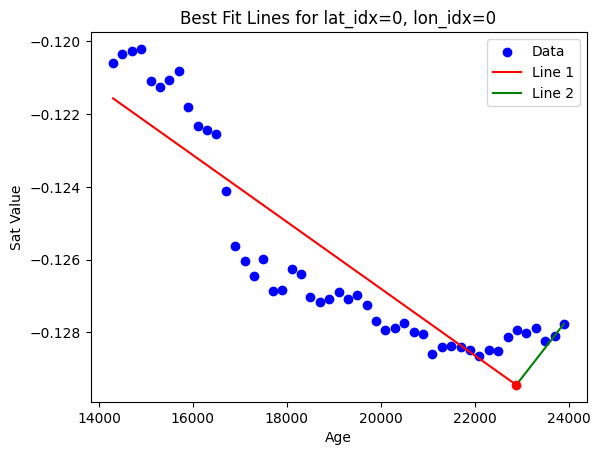

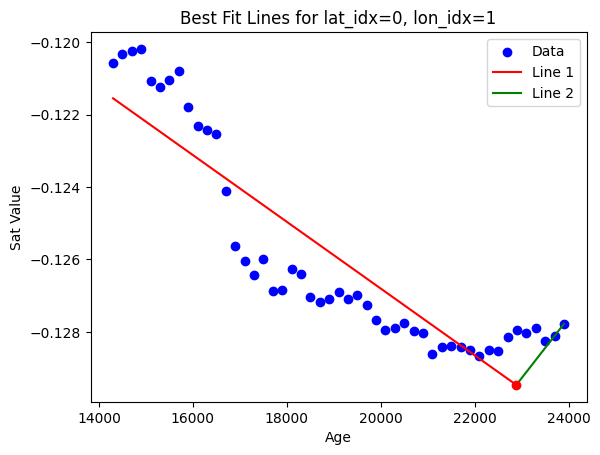

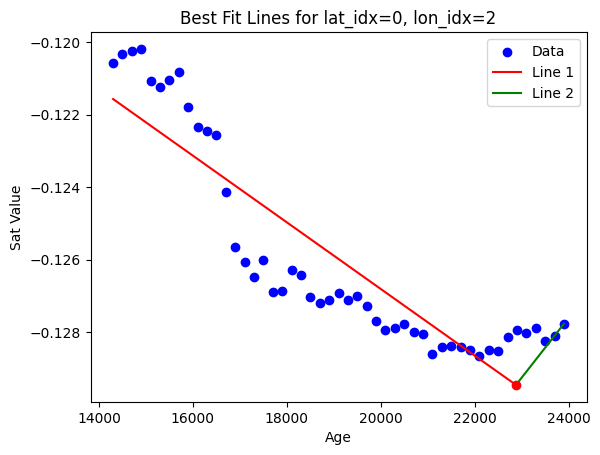

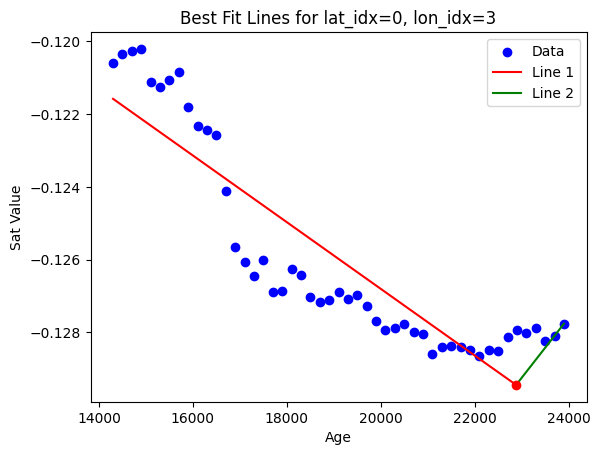

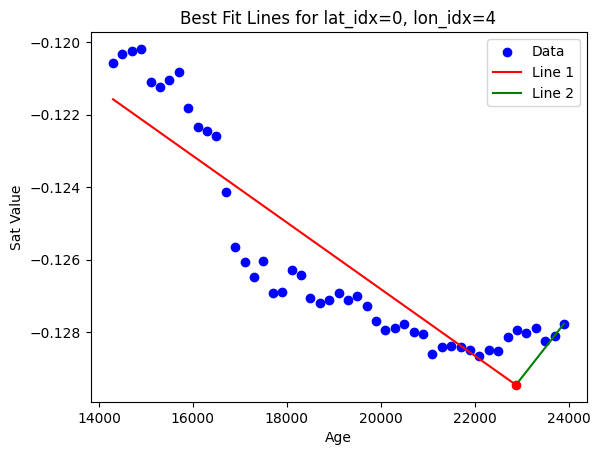

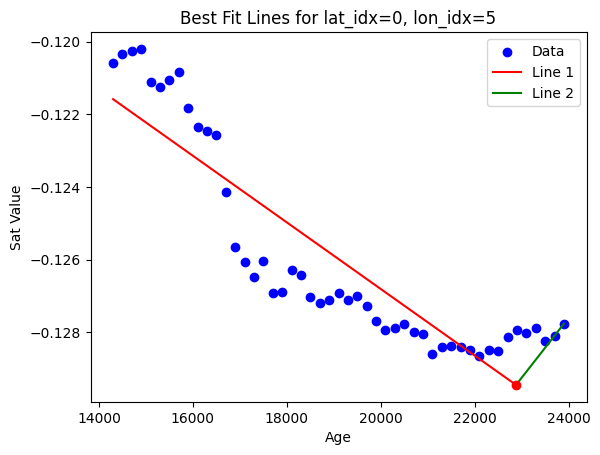

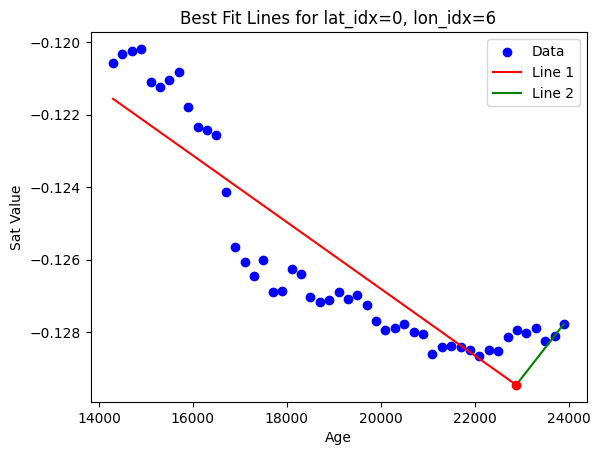

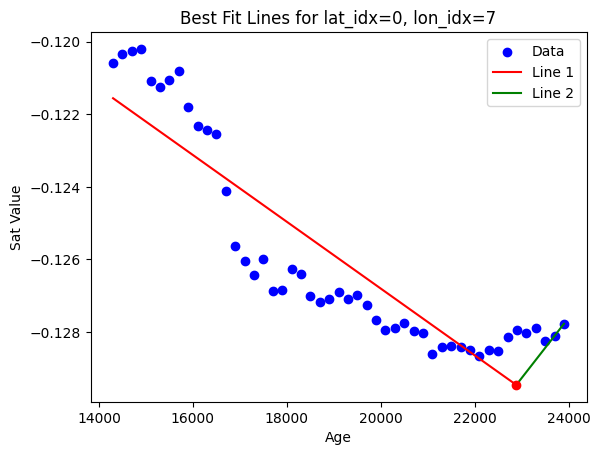

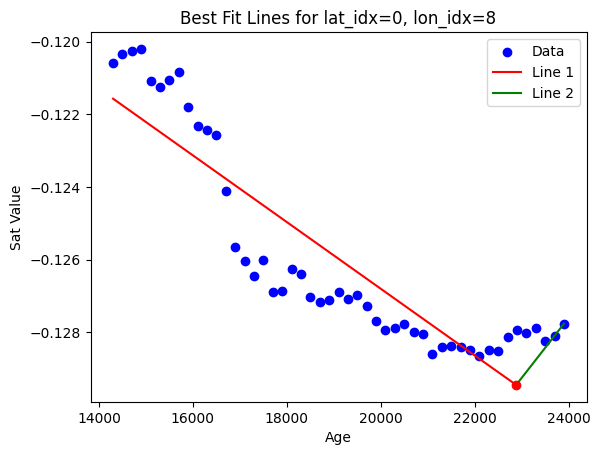

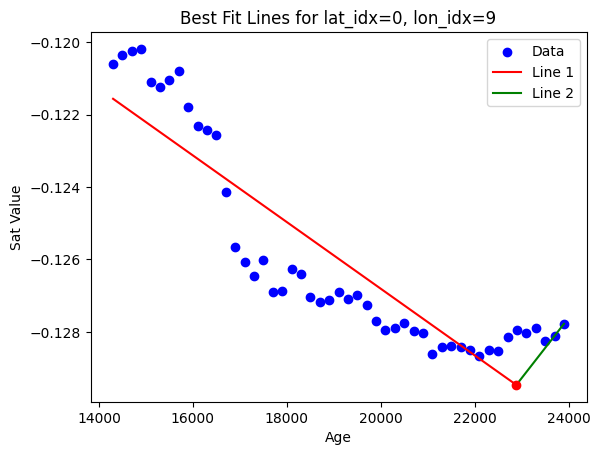

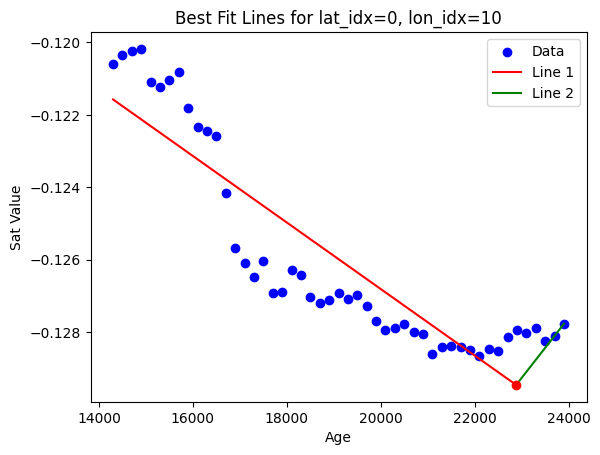

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import xarray as xr

# Function for linear fit
def linear_fit(x, a, b):
    return a * x + b

# Initialize a 2D array to store the 'best_fit_T' values
T_values_array = np.zeros((len(ds_sat_EOFs['lat']), len(ds_sat_EOFs['lon'])))
interval_L_indx=16
interval_R_indx=65

cropped_age = ds_sat_EOFs['age'].values[interval_L_indx:interval_R_indx]
transitions=cropped_age[1:-1]

counter=0

# Loop through each lat-lon grid point
for lat_idx in range(len(ds_sat_EOFs['lat'])):
    for lon_idx in range(len(ds_sat_EOFs['lon'])):
        
        time_series_data = ds_sat_EOFs['sat'].isel(lat=lat_idx, lon=lon_idx).values[interval_L_indx:interval_R_indx]

        # print(len(time_series_data))

        # skip if time_series_data is all zero
        if np.all(time_series_data==0):
            continue

        else:
            # Initialize variables to store the best fit information
            best_residuals = float('inf')
            best_fit_T = None
            
            # Loop through each possible transition point T
            for T_idx, T in enumerate(transitions):
                x1, y1 = cropped_age[:T_idx+2], time_series_data[:T_idx+2]
                x2, y2 = cropped_age[T_idx+1:], time_series_data[T_idx+1:]
                
                # Fit the two lines
                popt1, _ = curve_fit(linear_fit, x1, y1)
                popt2, _ = curve_fit(linear_fit, x2, y2)
                
                a1, b1 = popt1
                a2, b2 = popt2
                
                # Calculate residuals
                residuals = np.sum((linear_fit(x1, *popt1) - y1)**2) + np.sum((linear_fit(x2, *popt2) - y2)**2)
                
                # Update best fit if this fit is better
                if residuals < best_residuals:
                    best_residuals = residuals
                    intersect_age = (b2 - b1) / (a1 - a2)
                    best_fit_T = intersect_age

            # Store the best_fit_T in the 2D array
            T_values_array[lat_idx, lon_idx] = best_fit_T

            if counter <= 10:
                plt.figure()
                plt.scatter(cropped_age, time_series_data, label='Data', color='blue')
                
                # Calculate intersection and extend x-range to include the intersection
                intersect_age = (b2 - b1) / (a1 - a2)
                intersect_sat = linear_fit(intersect_age, *popt1)
                extended_x1 = np.linspace(min(x1), intersect_age, 100)
                extended_x2 = np.linspace(intersect_age, max(x2), 100)
                
                plt.plot(extended_x1, linear_fit(extended_x1, *popt1), label='Line 1', color='red')
                plt.plot(extended_x2, linear_fit(extended_x2, *popt2), label='Line 2', color='green')
                
                # Mark the intersection with a red dot
                plt.scatter([intersect_age], [intersect_sat], color='red', zorder=5)
                
                plt.legend()
                plt.xlabel('Age')
                plt.ylabel('Sat Value')
                plt.title(f'Best Fit Lines for lat_idx={lat_idx}, lon_idx={lon_idx}')
                plt.show()
                
            counter += 1


# Plot the spatial distribution of the transition age

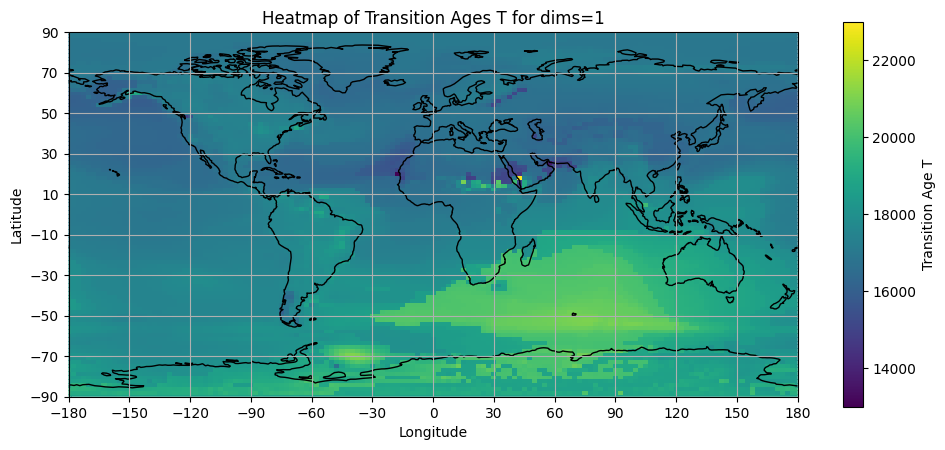

In [27]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Create a figure with a single subplot with map projection
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastline to the subplot
ax.add_feature(cfeature.COASTLINE)

# Using pcolormesh for the heatmap of transition ages
c = ax.pcolormesh(ds_sat_EOFs['lon'], ds_sat_EOFs['lat'], T_values_array, shading='auto', vmin=13000, vmax=23000)

# Adding colorbar and labels
plt.colorbar(c, ax=ax, shrink=0.5, label='Transition Age T')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Heatmap of Transition Ages T for dims=1')

# Add lat-lon grid with 10-degree steps
ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 20), crs=ccrs.PlateCarree())
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
